In [55]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense, SpatialDropout2D
from keras import backend as K
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, TensorBoard, EarlyStopping
from keras.constraints import max_norm
import numpy as np
from tensorflow.keras.layers import BatchNormalization

# dimensions of our images.
img_width, img_height = 100, 100

train_data_dir = 'dataset/Training/'
validation_data_dir = 'dataset/Test/'
nb_train_samples = 28839
nb_validation_samples = 6970
epochs = 2
batch_size = 32

if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(32, (3, 3), kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(64, (3, 3), kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(128, (3, 3), kernel_constraint=max_norm(3), bias_constraint=max_norm(3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(1))
model.add(Activation('sigmoid'))

model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])



In [56]:
model.summary()

Model: "sequential_26"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_91 (Conv2D)           (None, 98, 98, 32)        896       
_________________________________________________________________
batch_normalization (BatchNo (None, 98, 98, 32)        128       
_________________________________________________________________
activation_138 (Activation)  (None, 98, 98, 32)        0         
_________________________________________________________________
max_pooling2d_90 (MaxPooling (None, 49, 49, 32)        0         
_________________________________________________________________
conv2d_92 (Conv2D)           (None, 47, 47, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 47, 47, 32)        128       
_________________________________________________________________
activation_139 (Activation)  (None, 47, 47, 32)      

In [57]:
# augmentation 
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# augmentation 
# only rescaling
test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

checkpoint = ModelCheckpoint("first1_cp.h5", monitor='val_acc', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq=5)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=nb_train_samples // batch_size,
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=nb_validation_samples // batch_size)

Found 28817 images belonging to 2 classes.
Found 6970 images belonging to 2 classes.
Epoch 1/2
901/901 [==============================] - 257s 284ms/step - loss: 0.1818 - accuracy: 0.9503 - val_loss: 1.9291 - val_accuracy: 0.6357
Epoch 2/2
901/901 [==============================] - 252s 279ms/step - loss: 0.0531 - accuracy: 0.9866 - val_loss: 3.6916 - val_accuracy: 0.6237


In [58]:
model.save('fire_detection_model.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


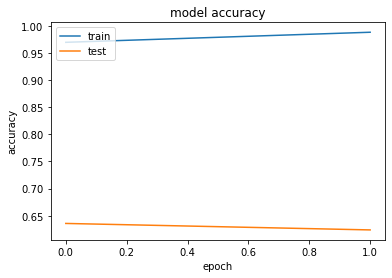

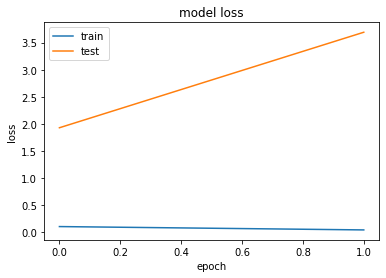

In [59]:
import matplotlib.pyplot as plt
%matplotlib inline
# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [60]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)
y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
print(confusion_matrix(validation_generator.classes, y_pred))
print('Classification Report')
target_names = ['Fire', 'No Fire']
print(classification_report(validation_generator.classes, y_pred, target_names=target_names))

Confusion Matrix
[[3490    0]
 [3480    0]]
Classification Report
              precision    recall  f1-score   support

        Fire       0.50      1.00      0.67      3490
     No Fire       0.00      0.00      0.00      3480

    accuracy                           0.50      6970
   macro avg       0.25      0.50      0.33      6970
weighted avg       0.25      0.50      0.33      6970

